**Forecasting Several Timesteps ahead:**
- Done - predicting and using the predictions to keep on predicting more values by feeding them back into the model. 
- The second option we've got is to train a rnn to predict the next 14 values in one shot. We can still use a sequence to vector model but it will output 14 values instead of one. We need to change the targets to be vectors containing the next 14 values. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils.early_stopping import EarlyStopping
from utils.fetch_data import create_multidim_chunks2, create_splits_mulvar, train_encoder, transform_split, fetch_timeseries_data
from utils.load_data import TimeSeriesDataset2
from utils.train_model import train_multi_d

In [2]:
import importlib
import utils.fetch_data as fd
importlib.reload(fd)
transform_split = fd.transform_split

Fetch the dataset:

In [3]:
df = fetch_timeseries_data()

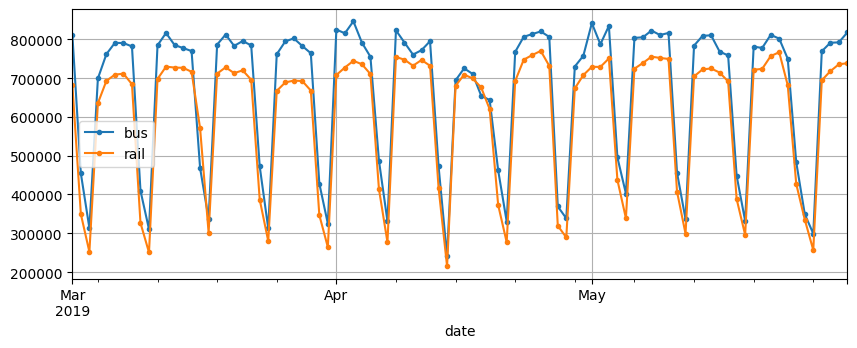

In [4]:
df['2019-03':'2019-05'].plot(grid=True, marker='.',figsize=(10,3.5))
plt.show()

In [5]:
mulvar_train, mulvar_valid, mulvar_test = create_splits_mulvar(df)

In [6]:
encoder = train_encoder(mulvar_train) # train onehot encoder

In [7]:
# get the transformed dataframes
mulvar_train, mulvar_valid, mulvar_test = transform_split(mulvar_train, encoder), transform_split(mulvar_valid, encoder), transform_split(mulvar_test, encoder)

In [8]:
# create chunks
mv_train_chunks, mv_valid_chunks, mv_test_chunks = create_multidim_chunks2(56, mulvar_train, 14), create_multidim_chunks2(56, mulvar_valid, 14), create_multidim_chunks2(56, mulvar_test, 14)

In [9]:
torch.manual_seed(1)

create the datasets

In [10]:
mv_train_ds = TimeSeriesDataset2(torch.tensor(np.array(mv_train_chunks), dtype=torch.float32), seq_length=56)
mv_valid_ds = TimeSeriesDataset2(torch.tensor(np.array(mv_valid_chunks), dtype=torch.float32), seq_length=56)
mv_test_ds = TimeSeriesDataset2(torch.tensor(np.array(mv_test_chunks), dtype=torch.float32), seq_length=56)

In [11]:
mv_train_dl = DataLoader(mv_train_ds, batch_size=64, shuffle=True)
mv_valid_dl = DataLoader(mv_valid_ds, batch_size=64)
mv_test_dl = DataLoader(mv_test_ds, batch_size=1024)

In [12]:
z,y = mv_train_ds[0]

In [13]:
z.shape

torch.Size([56, 5])

In [14]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [15]:
class UnivarModel2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 14)
    
    def forward(self, x):
        out, hn = self.rnn(x)
        return self.linear(hn[-1, :, :])

In [16]:
torch.manual_seed(1)
univar_model2 = UnivarModel2(5,32).to(device)

In [17]:
#optimizer = torch.optim.SGD(univar_model.parameters(), lr=0.002, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(univar_model2.parameters(), lr=0.02)
criterion = nn.HuberLoss(reduction='sum')
early_stopper = EarlyStopping(patience=50, checkpoint_path = 'univar_model3.pt', restore_best_weights=True, verbose=True)
#cheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.009, epochs=500, steps_per_epoch=len(rail_train_dl))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=5)

In [18]:
t_loss, v_loss = train_multi_d(500, univar_model2, mv_train_dl, mv_valid_dl, device, criterion, optimizer, early_stopper, performance_scheduler=scheduler,other_scheduler=None, l1_norm=True, l1_lambda=3.0e-5)

Epoch: 1| Train loss: 0.5905| Val loss: 0.1396
Metric improved to 0.1396. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 0.1122| Val loss: 0.0464
Metric improved to 0.0464. Checkpoint saved at epoch 1
Epoch: 3| Train loss: 0.0665| Val loss: 0.0320
Metric improved to 0.0320. Checkpoint saved at epoch 2
Epoch: 4| Train loss: 0.0557| Val loss: 0.0293
Metric improved to 0.0293. Checkpoint saved at epoch 3
Epoch: 5| Train loss: 0.0530| Val loss: 0.0330
No improvement for 1 epoch(s)
Epoch: 6| Train loss: 0.0530| Val loss: 0.0293
No improvement for 2 epoch(s)
Epoch: 7| Train loss: 0.0514| Val loss: 0.0221
Metric improved to 0.0221. Checkpoint saved at epoch 6
Epoch: 8| Train loss: 0.0500| Val loss: 0.0384
No improvement for 1 epoch(s)
Epoch: 9| Train loss: 0.0548| Val loss: 0.0304
No improvement for 2 epoch(s)
Epoch: 10| Train loss: 0.0522| Val loss: 0.0309
No improvement for 3 epoch(s)
Epoch: 11| Train loss: 0.0548| Val loss: 0.0248
No improvement for 4 epoch(s)
Epoch: 12| Train loss: 0.0

In [19]:
l1_loss = nn.L1Loss(reduction='sum')

loss_ = []

with torch.no_grad():
    for x_test_batch, y_test_batch in mv_test_dl:
        x_test_batch = x_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)
        hn = univar_model2(x_test_batch)
        loss = l1_loss(hn, y_test_batch)
        loss_.append(loss.item())

In [20]:
sum(loss_)/len(mv_test_dl.dataset)*1e6

2053797.8864082263

In [29]:
pred_set = mulvar_valid.iloc[-70:-14:,:]

In [30]:
pred_set.shape

(56, 5)

In [37]:
with torch.no_grad():
    res = univar_model2(torch.tensor(pred_set.values, dtype=torch.float32, device=device).unsqueeze(0))
    print(res)

tensor([[0.4142, 0.2956, 0.6590, 0.7280, 0.7132, 0.7063, 0.6960, 0.4032, 0.2980,
         0.6637, 0.7121, 0.7040, 0.7015, 0.6892]], device='mps:0')


In [38]:
index = mulvar_valid.iloc[-14:,:].index

In [40]:
index

DatetimeIndex(['2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [49]:
res_df = pd.DataFrame(
    res.detach().reshape(14,).cpu().numpy(),
    index=index,
    columns=['pred']
)

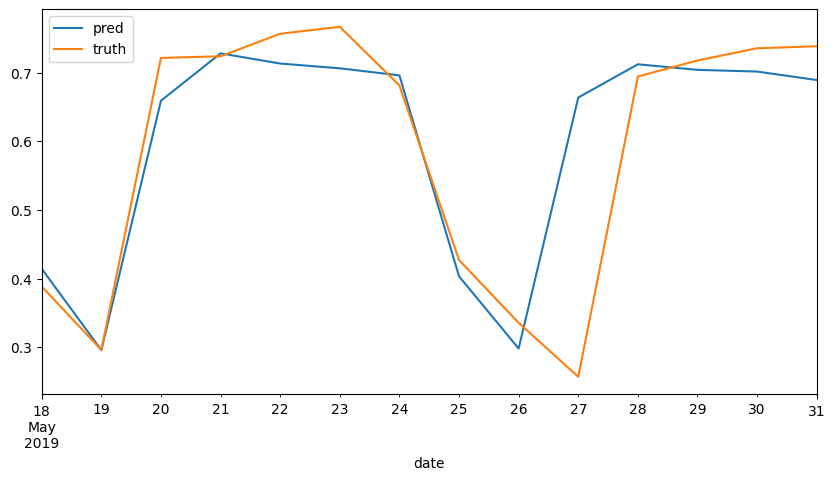

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
res_df.plot(kind='line', ax=ax, label='pred')
mulvar_valid.iloc[-14:,1].plot(kind='line', ax=ax,label='truth')
ax.legend()